# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 5079040/11490434 [============>.................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 13:00 - loss: 0.6942

  28/1875 [..............................] - ETA: 3s - loss: 0.5492   

  60/1875 [..............................] - ETA: 3s - loss: 0.4616

  95/1875 [>.............................] - ETA: 2s - loss: 0.4150

 131/1875 [=>............................] - ETA: 2s - loss: 0.3860

 163/1875 [=>............................] - ETA: 2s - loss: 0.3675

 193/1875 [==>...........................] - ETA: 2s - loss: 0.3536

 220/1875 [==>...........................] - ETA: 2s - loss: 0.3432

 247/1875 [==>...........................] - ETA: 2s - loss: 0.3341

 274/1875 [===>..........................] - ETA: 2s - loss: 0.3261

 305/1875 [===>..........................] - ETA: 2s - loss: 0.3179

 339/1875 [====>.........................] - ETA: 2s - loss: 0.3100

 371/1875 [====>.........................] - ETA: 2s - loss: 0.3034

 398/1875 [=====>........................] - ETA: 2s - loss: 0.2984

 426/1875 [=====>........................] - ETA: 2s - loss: 0.2935

 454/1875 [======>.......................] - ETA: 2s - loss: 0.2890

 487/1875 [======>.......................] - ETA: 2s - loss: 0.2841

 521/1875 [=======>......................] - ETA: 2s - loss: 0.2795

 552/1875 [=======>......................] - ETA: 2s - loss: 0.2755

 582/1875 [========>.....................] - ETA: 2s - loss: 0.2720

 611/1875 [========>.....................] - ETA: 2s - loss: 0.2687

 646/1875 [=========>....................] - ETA: 2s - loss: 0.2651

 676/1875 [=========>....................] - ETA: 1s - loss: 0.2621

 706/1875 [==========>...................] - ETA: 1s - loss: 0.2593

 735/1875 [==========>...................] - ETA: 1s - loss: 0.2567

 756/1875 [===========>..................] - ETA: 1s - loss: 0.2549

 782/1875 [===========>..................] - ETA: 1s - loss: 0.2527

 811/1875 [===========>..................] - ETA: 1s - loss: 0.2504

 835/1875 [============>.................] - ETA: 1s - loss: 0.2486

 861/1875 [============>.................] - ETA: 1s - loss: 0.2467

 886/1875 [=============>................] - ETA: 1s - loss: 0.2449

 914/1875 [=============>................] - ETA: 1s - loss: 0.2430

 938/1875 [==============>...............] - ETA: 1s - loss: 0.2414

 964/1875 [==============>...............] - ETA: 1s - loss: 0.2397

 988/1875 [==============>...............] - ETA: 1s - loss: 0.2383

1017/1875 [===============>..............] - ETA: 1s - loss: 0.2365

1040/1875 [===============>..............] - ETA: 1s - loss: 0.2352

1062/1875 [===============>..............] - ETA: 1s - loss: 0.2339

1084/1875 [================>.............] - ETA: 1s - loss: 0.2327

1108/1875 [================>.............] - ETA: 1s - loss: 0.2314

1133/1875 [=================>............] - ETA: 1s - loss: 0.2301

1161/1875 [=================>............] - ETA: 1s - loss: 0.2286

1192/1875 [==================>...........] - ETA: 1s - loss: 0.2271

1214/1875 [==================>...........] - ETA: 1s - loss: 0.2260

1240/1875 [==================>...........] - ETA: 1s - loss: 0.2248

1268/1875 [===================>..........] - ETA: 1s - loss: 0.2235

1296/1875 [===================>..........] - ETA: 1s - loss: 0.2223

1319/1875 [====================>.........] - ETA: 1s - loss: 0.2213

1339/1875 [====================>.........] - ETA: 0s - loss: 0.2204

1368/1875 [====================>.........] - ETA: 0s - loss: 0.2192

1396/1875 [=====================>........] - ETA: 0s - loss: 0.2181

1419/1875 [=====================>........] - ETA: 0s - loss: 0.2172

1445/1875 [======================>.......] - ETA: 0s - loss: 0.2161

1472/1875 [======================>.......] - ETA: 0s - loss: 0.2151

1496/1875 [======================>.......] - ETA: 0s - loss: 0.2142

1522/1875 [=======================>......] - ETA: 0s - loss: 0.2133

1545/1875 [=======================>......] - ETA: 0s - loss: 0.2124

1569/1875 [========================>.....] - ETA: 0s - loss: 0.2116

1593/1875 [========================>.....] - ETA: 0s - loss: 0.2108

1613/1875 [========================>.....] - ETA: 0s - loss: 0.2101

1640/1875 [=========================>....] - ETA: 0s - loss: 0.2092

1662/1875 [=========================>....] - ETA: 0s - loss: 0.2085

1688/1875 [==========================>...] - ETA: 0s - loss: 0.2076

1713/1875 [==========================>...] - ETA: 0s - loss: 0.2069

1743/1875 [==========================>...] - ETA: 0s - loss: 0.2059

1772/1875 [===========================>..] - ETA: 0s - loss: 0.2050

1800/1875 [===========================>..] - ETA: 0s - loss: 0.2042

1830/1875 [============================>.] - ETA: 0s - loss: 0.2033

1860/1875 [============================>.] - ETA: 0s - loss: 0.2025

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2020


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1035

  31/1875 [..............................] - ETA: 3s - loss: 0.1087

  62/1875 [..............................] - ETA: 2s - loss: 0.1089

  93/1875 [>.............................] - ETA: 2s - loss: 0.1090

 122/1875 [>.............................] - ETA: 2s - loss: 0.1091

 153/1875 [=>............................] - ETA: 2s - loss: 0.1091

 185/1875 [=>............................] - ETA: 2s - loss: 0.1090

 216/1875 [==>...........................] - ETA: 2s - loss: 0.1090

 247/1875 [==>...........................] - ETA: 2s - loss: 0.1089

 278/1875 [===>..........................] - ETA: 2s - loss: 0.1089

 309/1875 [===>..........................] - ETA: 2s - loss: 0.1088

 340/1875 [====>.........................] - ETA: 2s - loss: 0.1087

 370/1875 [====>.........................] - ETA: 2s - loss: 0.1086

 401/1875 [=====>........................] - ETA: 2s - loss: 0.1085

 433/1875 [=====>........................] - ETA: 2s - loss: 0.1085

 463/1875 [======>.......................] - ETA: 2s - loss: 0.1084

 494/1875 [======>.......................] - ETA: 2s - loss: 0.1083

 524/1875 [=======>......................] - ETA: 2s - loss: 0.1083

 555/1875 [=======>......................] - ETA: 2s - loss: 0.1082

 584/1875 [========>.....................] - ETA: 2s - loss: 0.1081

 614/1875 [========>.....................] - ETA: 2s - loss: 0.1080

 643/1875 [=========>....................] - ETA: 2s - loss: 0.1080

 671/1875 [=========>....................] - ETA: 2s - loss: 0.1079

 698/1875 [==========>...................] - ETA: 1s - loss: 0.1078

 728/1875 [==========>...................] - ETA: 1s - loss: 0.1078

 759/1875 [===========>..................] - ETA: 1s - loss: 0.1077

 790/1875 [===========>..................] - ETA: 1s - loss: 0.1076

 821/1875 [============>.................] - ETA: 1s - loss: 0.1075

 851/1875 [============>.................] - ETA: 1s - loss: 0.1074

 881/1875 [=============>................] - ETA: 1s - loss: 0.1074

 910/1875 [=============>................] - ETA: 1s - loss: 0.1073

 940/1875 [==============>...............] - ETA: 1s - loss: 0.1072

 970/1875 [==============>...............] - ETA: 1s - loss: 0.1072

1000/1875 [===============>..............] - ETA: 1s - loss: 0.1071

1031/1875 [===============>..............] - ETA: 1s - loss: 0.1070

1061/1875 [===============>..............] - ETA: 1s - loss: 0.1070

1092/1875 [================>.............] - ETA: 1s - loss: 0.1069

1123/1875 [================>.............] - ETA: 1s - loss: 0.1068

1154/1875 [=================>............] - ETA: 1s - loss: 0.1068

1185/1875 [=================>............] - ETA: 1s - loss: 0.1067

1215/1875 [==================>...........] - ETA: 1s - loss: 0.1066

1245/1875 [==================>...........] - ETA: 1s - loss: 0.1066

1276/1875 [===================>..........] - ETA: 1s - loss: 0.1065

1307/1875 [===================>..........] - ETA: 0s - loss: 0.1065

1338/1875 [====================>.........] - ETA: 0s - loss: 0.1064

1369/1875 [====================>.........] - ETA: 0s - loss: 0.1063

1400/1875 [=====================>........] - ETA: 0s - loss: 0.1063

1432/1875 [=====================>........] - ETA: 0s - loss: 0.1062

1463/1875 [======================>.......] - ETA: 0s - loss: 0.1062

1493/1875 [======================>.......] - ETA: 0s - loss: 0.1061

1524/1875 [=======================>......] - ETA: 0s - loss: 0.1061

1555/1875 [=======================>......] - ETA: 0s - loss: 0.1060

1586/1875 [========================>.....] - ETA: 0s - loss: 0.1059

1616/1875 [========================>.....] - ETA: 0s - loss: 0.1059

1638/1875 [=========================>....] - ETA: 0s - loss: 0.1059

1664/1875 [=========================>....] - ETA: 0s - loss: 0.1058

1687/1875 [=========================>....] - ETA: 0s - loss: 0.1058

1713/1875 [==========================>...] - ETA: 0s - loss: 0.1057

1739/1875 [==========================>...] - ETA: 0s - loss: 0.1057

1769/1875 [===========================>..] - ETA: 0s - loss: 0.1056

1794/1875 [===========================>..] - ETA: 0s - loss: 0.1056

1822/1875 [============================>.] - ETA: 0s - loss: 0.1055

1854/1875 [============================>.] - ETA: 0s - loss: 0.1055

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1054


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0928

  23/1875 [..............................] - ETA: 4s - loss: 0.0977

  50/1875 [..............................] - ETA: 3s - loss: 0.0982

  78/1875 [>.............................] - ETA: 3s - loss: 0.0981

 105/1875 [>.............................] - ETA: 3s - loss: 0.0981

 134/1875 [=>............................] - ETA: 3s - loss: 0.0981

 159/1875 [=>............................] - ETA: 3s - loss: 0.0981

 185/1875 [=>............................] - ETA: 3s - loss: 0.0981

 211/1875 [==>...........................] - ETA: 3s - loss: 0.0981

 238/1875 [==>...........................] - ETA: 3s - loss: 0.0981

 266/1875 [===>..........................] - ETA: 3s - loss: 0.0981

 288/1875 [===>..........................] - ETA: 3s - loss: 0.0980

 319/1875 [====>.........................] - ETA: 2s - loss: 0.0980

 346/1875 [====>.........................] - ETA: 2s - loss: 0.0980

 372/1875 [====>.........................] - ETA: 2s - loss: 0.0980

 397/1875 [=====>........................] - ETA: 2s - loss: 0.0980

 424/1875 [=====>........................] - ETA: 2s - loss: 0.0980

 449/1875 [======>.......................] - ETA: 2s - loss: 0.0980

 474/1875 [======>.......................] - ETA: 2s - loss: 0.0980

 505/1875 [=======>......................] - ETA: 2s - loss: 0.0980

 535/1875 [=======>......................] - ETA: 2s - loss: 0.0980

 565/1875 [========>.....................] - ETA: 2s - loss: 0.0980

 595/1875 [========>.....................] - ETA: 2s - loss: 0.0979

 624/1875 [========>.....................] - ETA: 2s - loss: 0.0979

 650/1875 [=========>....................] - ETA: 2s - loss: 0.0979

 674/1875 [=========>....................] - ETA: 2s - loss: 0.0979

 701/1875 [==========>...................] - ETA: 2s - loss: 0.0979

 727/1875 [==========>...................] - ETA: 2s - loss: 0.0979

 753/1875 [===========>..................] - ETA: 2s - loss: 0.0979

 781/1875 [===========>..................] - ETA: 2s - loss: 0.0979

 808/1875 [===========>..................] - ETA: 2s - loss: 0.0979

 835/1875 [============>.................] - ETA: 1s - loss: 0.0979

 859/1875 [============>.................] - ETA: 1s - loss: 0.0979

 886/1875 [=============>................] - ETA: 1s - loss: 0.0979

 916/1875 [=============>................] - ETA: 1s - loss: 0.0979

 943/1875 [==============>...............] - ETA: 1s - loss: 0.0979

 970/1875 [==============>...............] - ETA: 1s - loss: 0.0979

 993/1875 [==============>...............] - ETA: 1s - loss: 0.0979

1018/1875 [===============>..............] - ETA: 1s - loss: 0.0978

1048/1875 [===============>..............] - ETA: 1s - loss: 0.0978

1074/1875 [================>.............] - ETA: 1s - loss: 0.0978

1104/1875 [================>.............] - ETA: 1s - loss: 0.0978

1131/1875 [=================>............] - ETA: 1s - loss: 0.0978

1160/1875 [=================>............] - ETA: 1s - loss: 0.0978

1186/1875 [=================>............] - ETA: 1s - loss: 0.0978

1214/1875 [==================>...........] - ETA: 1s - loss: 0.0978

1239/1875 [==================>...........] - ETA: 1s - loss: 0.0978

1264/1875 [===================>..........] - ETA: 1s - loss: 0.0978

1283/1875 [===================>..........] - ETA: 1s - loss: 0.0978

1306/1875 [===================>..........] - ETA: 1s - loss: 0.0978

1333/1875 [====================>.........] - ETA: 1s - loss: 0.0978

1360/1875 [====================>.........] - ETA: 0s - loss: 0.0978

1387/1875 [=====================>........] - ETA: 0s - loss: 0.0977

1415/1875 [=====================>........] - ETA: 0s - loss: 0.0977

1443/1875 [======================>.......] - ETA: 0s - loss: 0.0977

1462/1875 [======================>.......] - ETA: 0s - loss: 0.0977

1482/1875 [======================>.......] - ETA: 0s - loss: 0.0977

1503/1875 [=======================>......] - ETA: 0s - loss: 0.0977

1525/1875 [=======================>......] - ETA: 0s - loss: 0.0977

1549/1875 [=======================>......] - ETA: 0s - loss: 0.0977

1572/1875 [========================>.....] - ETA: 0s - loss: 0.0977

1601/1875 [========================>.....] - ETA: 0s - loss: 0.0977

1629/1875 [=========================>....] - ETA: 0s - loss: 0.0977

1658/1875 [=========================>....] - ETA: 0s - loss: 0.0977

1686/1875 [=========================>....] - ETA: 0s - loss: 0.0977

1713/1875 [==========================>...] - ETA: 0s - loss: 0.0977

1742/1875 [==========================>...] - ETA: 0s - loss: 0.0976

1772/1875 [===========================>..] - ETA: 0s - loss: 0.0976

1802/1875 [===========================>..] - ETA: 0s - loss: 0.0976

1832/1875 [============================>.] - ETA: 0s - loss: 0.0976

1861/1875 [============================>.] - ETA: 0s - loss: 0.0976

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0976


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0988

  31/1875 [..............................] - ETA: 3s - loss: 0.0945

  60/1875 [..............................] - ETA: 3s - loss: 0.0948

  89/1875 [>.............................] - ETA: 3s - loss: 0.0949

 118/1875 [>.............................] - ETA: 3s - loss: 0.0950

 146/1875 [=>............................] - ETA: 3s - loss: 0.0950

 173/1875 [=>............................] - ETA: 3s - loss: 0.0951

 200/1875 [==>...........................] - ETA: 2s - loss: 0.0952

 226/1875 [==>...........................] - ETA: 2s - loss: 0.0953

 252/1875 [===>..........................] - ETA: 2s - loss: 0.0954

 280/1875 [===>..........................] - ETA: 2s - loss: 0.0954

 308/1875 [===>..........................] - ETA: 2s - loss: 0.0955

 336/1875 [====>.........................] - ETA: 2s - loss: 0.0955

 364/1875 [====>.........................] - ETA: 2s - loss: 0.0956

 392/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 419/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 447/1875 [======>.......................] - ETA: 2s - loss: 0.0957

 476/1875 [======>.......................] - ETA: 2s - loss: 0.0957

 506/1875 [=======>......................] - ETA: 2s - loss: 0.0957

 536/1875 [=======>......................] - ETA: 2s - loss: 0.0958

 565/1875 [========>.....................] - ETA: 2s - loss: 0.0958

 593/1875 [========>.....................] - ETA: 2s - loss: 0.0958

 617/1875 [========>.....................] - ETA: 2s - loss: 0.0958

 643/1875 [=========>....................] - ETA: 2s - loss: 0.0958

 669/1875 [=========>....................] - ETA: 2s - loss: 0.0958

 696/1875 [==========>...................] - ETA: 2s - loss: 0.0958

 727/1875 [==========>...................] - ETA: 2s - loss: 0.0958

 755/1875 [===========>..................] - ETA: 2s - loss: 0.0958

 774/1875 [===========>..................] - ETA: 2s - loss: 0.0958

 800/1875 [===========>..................] - ETA: 1s - loss: 0.0958

 827/1875 [============>.................] - ETA: 1s - loss: 0.0958

 851/1875 [============>.................] - ETA: 1s - loss: 0.0958

 881/1875 [=============>................] - ETA: 1s - loss: 0.0958

 910/1875 [=============>................] - ETA: 1s - loss: 0.0959

 941/1875 [==============>...............] - ETA: 1s - loss: 0.0959

 972/1875 [==============>...............] - ETA: 1s - loss: 0.0959

1003/1875 [===============>..............] - ETA: 1s - loss: 0.0959

1034/1875 [===============>..............] - ETA: 1s - loss: 0.0959

1064/1875 [================>.............] - ETA: 1s - loss: 0.0959

1095/1875 [================>.............] - ETA: 1s - loss: 0.0959

1126/1875 [=================>............] - ETA: 1s - loss: 0.0959

1156/1875 [=================>............] - ETA: 1s - loss: 0.0959

1177/1875 [=================>............] - ETA: 1s - loss: 0.0959

1202/1875 [==================>...........] - ETA: 1s - loss: 0.0959

1222/1875 [==================>...........] - ETA: 1s - loss: 0.0959

1246/1875 [==================>...........] - ETA: 1s - loss: 0.0959

1273/1875 [===================>..........] - ETA: 1s - loss: 0.0959

1300/1875 [===================>..........] - ETA: 1s - loss: 0.0959

1324/1875 [====================>.........] - ETA: 1s - loss: 0.0959

1351/1875 [====================>.........] - ETA: 0s - loss: 0.0959

1377/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1396/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1425/1875 [=====================>........] - ETA: 0s - loss: 0.0959

1455/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1479/1875 [======================>.......] - ETA: 0s - loss: 0.0959

1504/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1532/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1561/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1585/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1614/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1640/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1668/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1686/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1714/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1741/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1762/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1790/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1819/1875 [============================>.] - ETA: 0s - loss: 0.0959

1847/1875 [============================>.] - ETA: 0s - loss: 0.0959

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0959


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1036

  31/1875 [..............................] - ETA: 3s - loss: 0.0972

  61/1875 [..............................] - ETA: 3s - loss: 0.0963

  90/1875 [>.............................] - ETA: 3s - loss: 0.0960

 119/1875 [>.............................] - ETA: 3s - loss: 0.0959

 148/1875 [=>............................] - ETA: 2s - loss: 0.0958

 176/1875 [=>............................] - ETA: 2s - loss: 0.0958

 205/1875 [==>...........................] - ETA: 2s - loss: 0.0957

 234/1875 [==>...........................] - ETA: 2s - loss: 0.0957

 264/1875 [===>..........................] - ETA: 2s - loss: 0.0957

 293/1875 [===>..........................] - ETA: 2s - loss: 0.0956

 321/1875 [====>.........................] - ETA: 2s - loss: 0.0956

 350/1875 [====>.........................] - ETA: 2s - loss: 0.0956

 380/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 409/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 438/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 467/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 496/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 523/1875 [=======>......................] - ETA: 2s - loss: 0.0955

 552/1875 [=======>......................] - ETA: 2s - loss: 0.0955

 580/1875 [========>.....................] - ETA: 2s - loss: 0.0955

 608/1875 [========>.....................] - ETA: 2s - loss: 0.0955

 636/1875 [=========>....................] - ETA: 2s - loss: 0.0955

 664/1875 [=========>....................] - ETA: 2s - loss: 0.0955

 692/1875 [==========>...................] - ETA: 2s - loss: 0.0955

 722/1875 [==========>...................] - ETA: 2s - loss: 0.0955

 752/1875 [===========>..................] - ETA: 1s - loss: 0.0954

 782/1875 [===========>..................] - ETA: 1s - loss: 0.0954

 812/1875 [===========>..................] - ETA: 1s - loss: 0.0954

 843/1875 [============>.................] - ETA: 1s - loss: 0.0954

 873/1875 [============>.................] - ETA: 1s - loss: 0.0954

 898/1875 [=============>................] - ETA: 1s - loss: 0.0954

 920/1875 [=============>................] - ETA: 1s - loss: 0.0954

 949/1875 [==============>...............] - ETA: 1s - loss: 0.0954

 975/1875 [==============>...............] - ETA: 1s - loss: 0.0954

 997/1875 [==============>...............] - ETA: 1s - loss: 0.0954

1022/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1048/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1072/1875 [================>.............] - ETA: 1s - loss: 0.0954

1098/1875 [================>.............] - ETA: 1s - loss: 0.0954

1130/1875 [=================>............] - ETA: 1s - loss: 0.0954

1161/1875 [=================>............] - ETA: 1s - loss: 0.0954

1191/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1215/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1239/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1268/1875 [===================>..........] - ETA: 1s - loss: 0.0954

1298/1875 [===================>..........] - ETA: 1s - loss: 0.0954

1326/1875 [====================>.........] - ETA: 0s - loss: 0.0954

1351/1875 [====================>.........] - ETA: 0s - loss: 0.0954

1377/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1402/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1428/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1451/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1479/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1505/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1530/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1556/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1581/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1608/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1639/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1666/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1694/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1724/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1753/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1783/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1812/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1841/1875 [============================>.] - ETA: 0s - loss: 0.0953

1871/1875 [============================>.] - ETA: 0s - loss: 0.0953

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0953


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

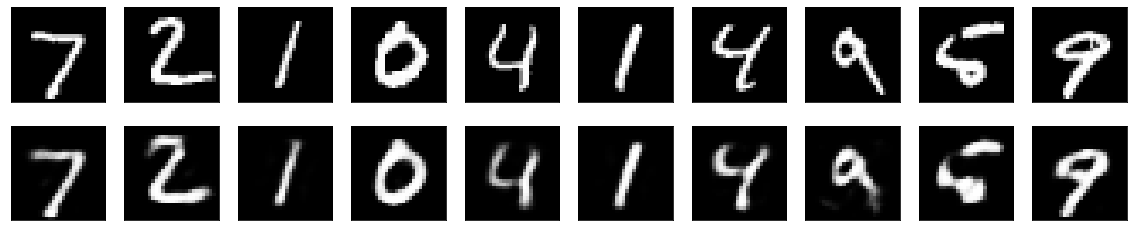

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
